In [1]:
import pandas as pd
pd.set_option("display.float_format", "{:.3f}".format)
pd.set_option("display.max_columns", 80)
pd.set_option("display.max_rows", 80)
import numpy as np

# Visualization
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

# Modeling & benchmarking
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, \
                                    StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import shap
from shap.plots import waterfall

# Dealing with imbalanced classes
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline

# Helper functions
from helper_functions import make_confusion_matrix

In [2]:
df_train = pd.read_csv("../data/processed_training.csv")
df_train.head(3)

,v2,v3,v5,v6,v7,v10,v13,v14,v17,v1_b,v4_y,v8_t,v9_t,v11_t,v12_p,v12_s,classLabel_yes.
0,-0.632,-0.457,-0.160,-1.448,0.000,-0.167,-0.146,-0.102,0,0,0,0,1,1,0,0,0
1,-0.691,-0.482,-0.428,-0.075,-0.324,-0.333,0.292,-0.107,0,1,1,0,0,0,0,1,0
2,0.152,-0.385,0.366,-0.150,-0.389,-0.167,-0.088,-0.089,0,1,0,0,1,0,0,0,0


In [3]:
df_val = pd.read_csv("../data/processed_validation.csv")
df_val.head(3)

,v2,v3,v5,v6,v7,v10,v13,v14,v17,v1_b,v4_y,v8_t,v9_t,v11_t,v12_p,v12_s,classLabel_yes.
0,0.163,0.728,0.309,-0.600,0.225,0.000,1.300,-0.009,1,1,0,1,0,1,0,1,0
1,-0.372,-0.121,-0.779,0.641,-0.209,0.000,-0.120,-0.007,0,1,0,0,0,1,0,0,0
2,0.413,-0.276,0.611,-0.279,-0.190,0.000,0.400,-0.003,1,1,1,0,0,0,0,0,0


#### **1.0 Train-test Split**

In [4]:
X_train = df_train.drop('classLabel_yes.', axis='columns')
y_train = df_train['classLabel_yes.']

print(X_train.shape)
print(y_train.shape)

(3700, 16)
(3700,)


In [5]:
X_train.head(3)

,v2,v3,v5,v6,v7,v10,v13,v14,v17,v1_b,v4_y,v8_t,v9_t,v11_t,v12_p,v12_s
0,-0.632,-0.457,-0.160,-1.448,0.000,-0.167,-0.146,-0.102,0,0,0,0,1,1,0,0
1,-0.691,-0.482,-0.428,-0.075,-0.324,-0.333,0.292,-0.107,0,1,1,0,0,0,0,1
2,0.152,-0.385,0.366,-0.150,-0.389,-0.167,-0.088,-0.089,0,1,0,0,1,0,0,0


In [6]:
y_train.head(3)

0    0
1    0
2    0
Name: classLabel_yes., dtype: int64

In [7]:
X_test = df_val.drop('classLabel_yes.', axis='columns')
y_test = df_val['classLabel_yes.']

print(X_test.shape)
print(y_test.shape)

(200, 16)
(200,)


In [8]:
X_test.head(3)

,v2,v3,v5,v6,v7,v10,v13,v14,v17,v1_b,v4_y,v8_t,v9_t,v11_t,v12_p,v12_s
0,0.163,0.728,0.309,-0.600,0.225,0.000,1.300,-0.009,1,1,0,1,0,1,0,1
1,-0.372,-0.121,-0.779,0.641,-0.209,0.000,-0.120,-0.007,0,1,0,0,0,1,0,0
2,0.413,-0.276,0.611,-0.279,-0.190,0.000,0.400,-0.003,1,1,1,0,0,0,0,0


In [9]:
y_test.head(3)

0    0
1    0
2    0
Name: classLabel_yes., dtype: int64

#### **2.0 Baseline Logistic Regression**

We'll start off by training a simple Logistic Regression model. We'll use GridSearchCV for hyperparameter tuning, to select the best set of hyperparameters for a machine learning model. 

For the `scoring` parameter in GridSearchCV, we'll go with the *f1-score*. The *f1-score* takes both precision and recall into account. Precision measures the ability of the model to correctly identify positive samples, while recall measures the ability to find all positive samples. In imbalanced datasets, where the positive class dominates in this case, accuracy can be misleading because a classifier that always predicts the majority class can have a high accuracy. Hence, the *f1-score* provides a more balanced measure of performance that considers false positives and false negatives.

Cross-validation is also used to estimate how well a model will perform on unseen data by splitting the dataset into multiple subsets (folds) for training and testing. This is done via `StratifiedKFold()`

In [35]:
scoring = ['f1']

stratified_kfold = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

In [36]:
pipeline = imbpipeline(steps = [['classifier', LogisticRegression(random_state=42, max_iter=3000)]])

param_grid = {
    'classifier__penalty': ['l1','l2'],
    'classifier__C': [100, 10, 1.0, 0.1, 0.01],
    'classifier__solver': ['liblinear', 'saga'],
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,
    cv=stratified_kfold,
    refit='f1',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}\nBest Hyperparameters: {grid_search.best_params_}')

Cross-validation score: 1.0
Test score: 0.48453608247422686
Best Hyperparameters: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}


In [37]:
y_pred = grid_search.predict(X_test)
cm_gd = confusion_matrix(y_test, y_pred)

For the cross-validation score, **the model achieved a perfect F1-score of 1.0 during cross-validation**, indicating that it performed exceptionally well on the training data.

However, the test score (*f1-score*) on the test dataset is merely 0.4845. This is significantly lower than the cross-validation score, suggesting that **the model may not generalize as well to unseen data as it did during training**.

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.50      0.51       107
           1       0.47      0.51      0.48        93

    accuracy                           0.50       200
   macro avg       0.50      0.50      0.50       200
weighted avg       0.50      0.50      0.50       200



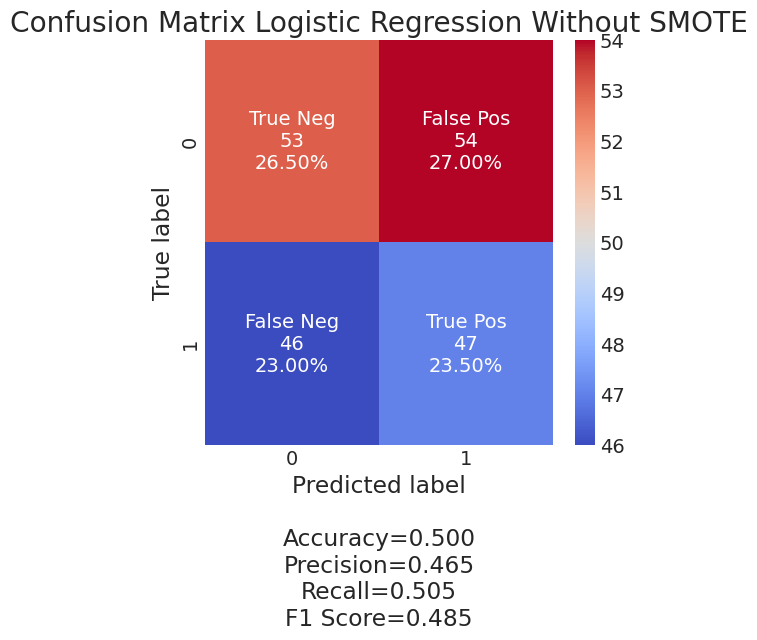

In [14]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(
    cm_gd, 
    group_names=labels,
    categories=categories, 
    cmap='coolwarm',
    figsize=(5,5),
    title="Confusion Matrix Logistic Regression Without SMOTE"
)

#### **3.0 Logistic Regression with SMOTE and Random Undersampling**

For our second approach, we'll use SMOTE and Random Undersampling. 

SMOTE is used to mitigate class imbalance by oversampling the minority class by generating synthetic samples. When one class is underrepresented, traditional machine learning algorithms can have a bias towards the majority class, leading to poor performance on the minority class. In our code, `sampling_strategy=0.2` means that the number of minority class samples will be increased to be 20% of the majority class samples.

After SMOTE, a RandomUnderSampler randomly selects a subset of the majority class samples to make the class distribution more balanced. In our code, `sampling_strategy=0.5` means that the majority class will be reduced to 50% of its original size.

Future explorations can benefit by specifying different SMOTE/RandomUnderSampling combinations or utilizing only one technique (instead of both).

In [15]:
# Define the SMOTE and RandomUnderSampler objects
smote = SMOTE(random_state=11, sampling_strategy=0.2)
random_undersampler = RandomUnderSampler(
    random_state=11,
    sampling_strategy=0.50
)

In [16]:
pipeline2 = imbpipeline(steps = [
    ['smote', smote],
    ['random_undersampling', random_undersampler],
    ['classifier', LogisticRegression(random_state=42,max_iter=3000)],
])
    
param_grid2 = {
    'classifier__penalty': ['l1','l2'],
    'classifier__C': [100, 10, 1.0, 0.1, 0.01],
    'classifier__solver': ['liblinear', 'saga'],
}

grid_search2 = GridSearchCV(
    estimator=pipeline2,
    param_grid=param_grid2,
    scoring=scoring,
    cv=stratified_kfold,
    refit='f1',
    n_jobs=-1
)

grid_search2.fit(X_train, y_train)
cv_score2 = grid_search2.best_score_
test_score2 = grid_search2.score(X_test, y_test)
print(f'Cross-validation score: {cv_score2}\nTest score: {test_score2}\nBest Hyperparameters: {grid_search2.best_params_}')

Cross-validation score: 1.0
Test score: 0.5
Best Hyperparameters: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}


In [17]:
y_pred2 = grid_search2.predict(X_test)
cm_gd2 = confusion_matrix(y_test, y_pred2)

Overall, while we see an overall improvement in all metrics, we fail at minimizing the instances of false positives and false negatives by a larger amount. Thus, there is still room for improvement, and further model tuning or other strategies may be necessary to enhance the model's performance.

In [18]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.55      0.50      0.52       107
           1       0.48      0.53      0.50        93

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.51       200
weighted avg       0.51      0.51      0.51       200



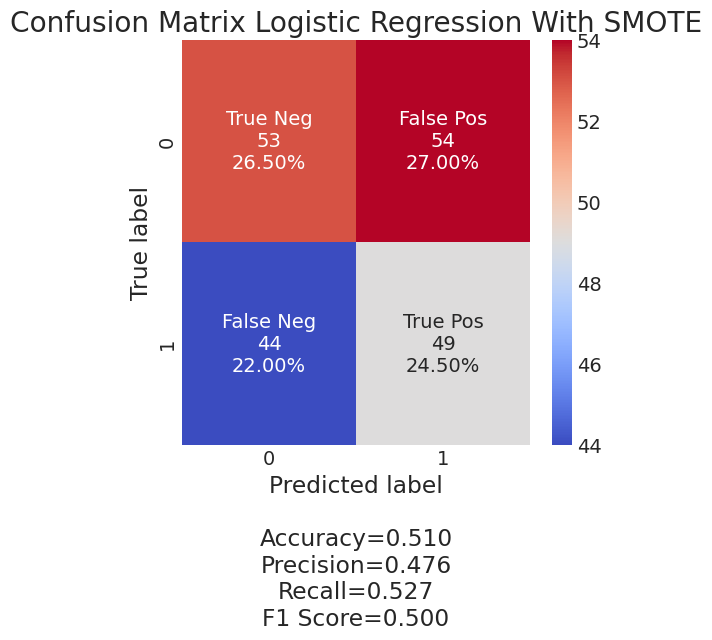

In [19]:
make_confusion_matrix(
    cm_gd2,
    group_names=labels,
    categories=categories, 
    cmap='coolwarm',
    figsize=(5,5),
    title="Confusion Matrix Logistic Regression With SMOTE"
)

#### **4.0 Analysis & Recommendations**

Overall, while there's a high cross-validation score, the model performs poorly on the test set, resulting in bad generalisability. We make several suggestions & hypotheses:

- We recommend updates on the dataset with **more instances of the *no.* class for the target**, `classLabel` **in the training set**. The bad generalisability is perhaps due to not enough learning examples from the minority class.
- Since we do not know the nature of each feature column, perhaps there **may have been a proxy feature that is directly or indirectly derived from the target column in the training set, leading to data leakage**. This can potentially explain it's extremely good performance on the training set.
- The **training set, which only has 3,700 rows, is extremely small**. A larget dataset can increase the odds of capturing more accurate distributions of the data.
- **Different SMOTE/Random under sampling parameters** can also be used in the future.
- Better data quality such as **less missing values** can also help improve the model.
- **More feature engineering work** also ought to be done.
- Finally, **different ML models** such as gradient boosting/neural networks can also be experimented with to see if they yield better performance. XGBoost, in particular, is robust to missing values.

#### **5.0 Feature Importance using SHAP**

SHAP (SHapley Additive exPlanations) values provide a way to attribute the prediction of a machine learning model to individual input features or variables, helping to understand the contributions of each feature to the model's output.

SHAP values represent how much each feature contributes to the model's prediction for each data point. Positive SHAP values indicate that the feature contributes positively to the prediction, while negative SHAP values indicate a negative contribution. The `shap_values` **object below contains the SHAP values for each instance in the combined dataset**, indicating the contribution of each feature to the model's predictions for that instance.

However, on the whole, **feature importance plots using SHAP are difficult to interpret with such imbalanced data**.

*Personal Notes:* https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html

In [41]:
model = grid_search2.best_estimator_
explainer = shap.Explainer(model.predict, X_train)

# generate SHAP values from a combination of test and training data
shap_values = explainer(pd.concat([X_test, X_train]))

PermutationExplainer explainer: 3901it [02:48, 21.97it/s]                          


From the below, we can say that `v17` has the largest sway over model output, followed by tenuous contributions from the other features. This warrants additional investigation into `v17` and it's correlation with `classLabel`.

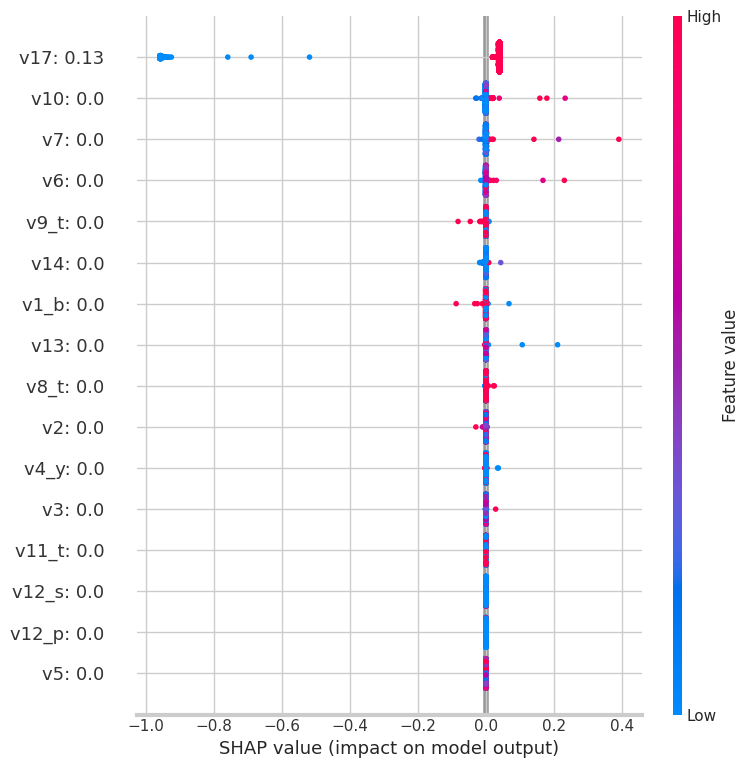

In [44]:
X = pd.concat([X_test, X_train])

# Note: https://stackoverflow.com/questions/72087719/shap-summary-plot-and-mean-values-displaying-together
feature_names = [
    a + ": " + str(b) for a,b in zip(X.columns, np.abs(shap_values.values).mean(0).round(2))
]

shap.summary_plot(shap_values, X, max_display=X.shape[1], 
                  feature_names=feature_names)

The 2 waterfall charts below show the features that were most important for a single example in the dataset and in this case it shows that `v17` is the most influential feature but we note that this is **not the case for the rest of the dataset** just these 2 examples.

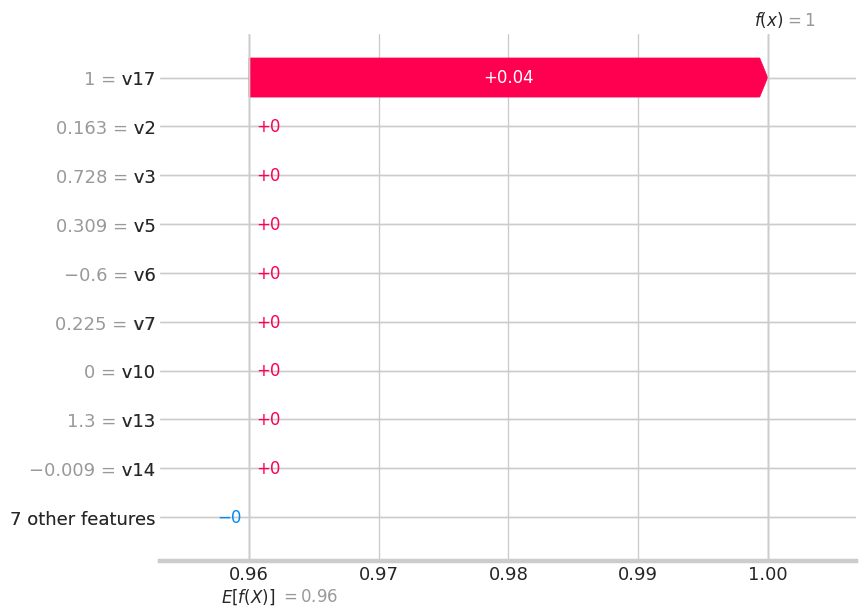

In [45]:
# waterfall chart 1
shap.plots.waterfall(shap_values[0])

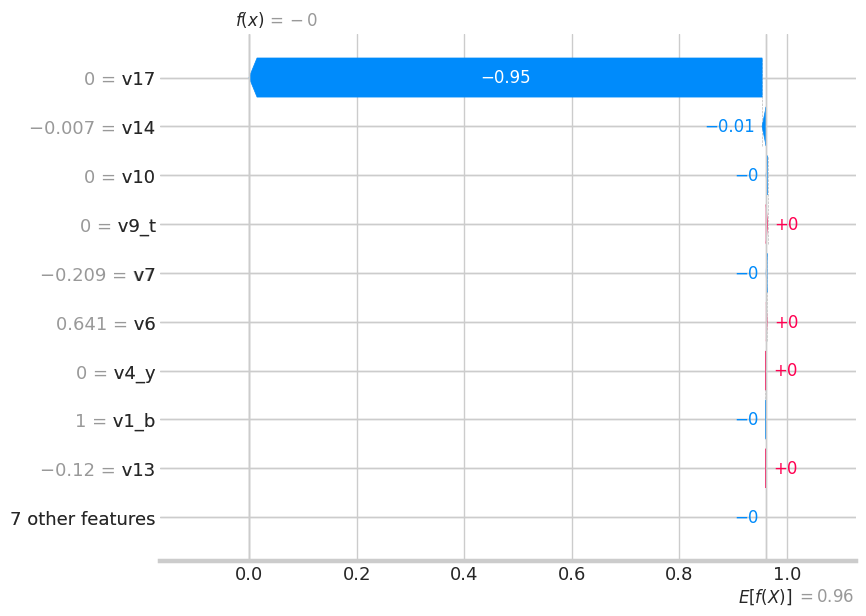

In [46]:
# waterfall chart 2
shap.plots.waterfall(shap_values[1])


The scatter plots that visualize the relationship between feature values and their corresponding SHAP values for a specific instance or set of instances. Barring `v17`, the rest of the top 4 features have no impact for the most part (detailed by their *clumping* of the the `y=0` axis). For `v17`, is a slightly positive predictor of `classLabel` when `v17=1` , and a negative predictor otherwise.

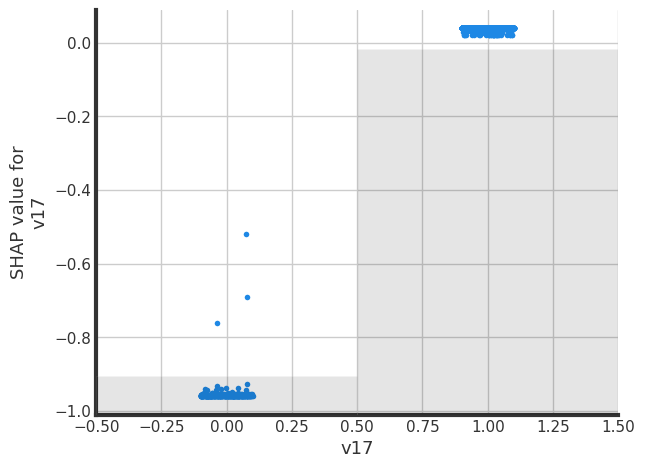

In [47]:
shap.plots.scatter(shap_values[:,"v17"])

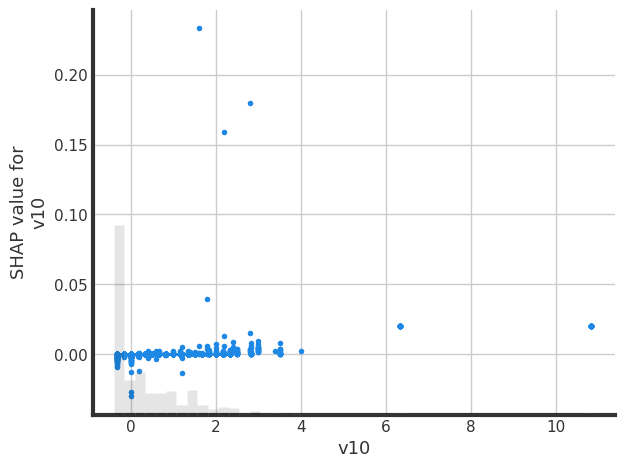

In [48]:
shap.plots.scatter(shap_values[:,"v10"])

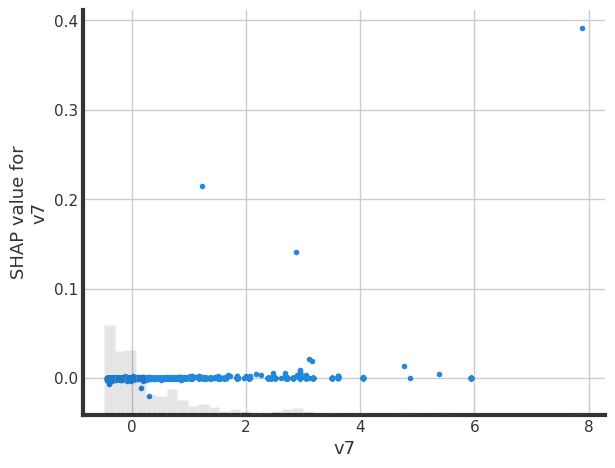

In [49]:
shap.plots.scatter(shap_values[:,"v7"])

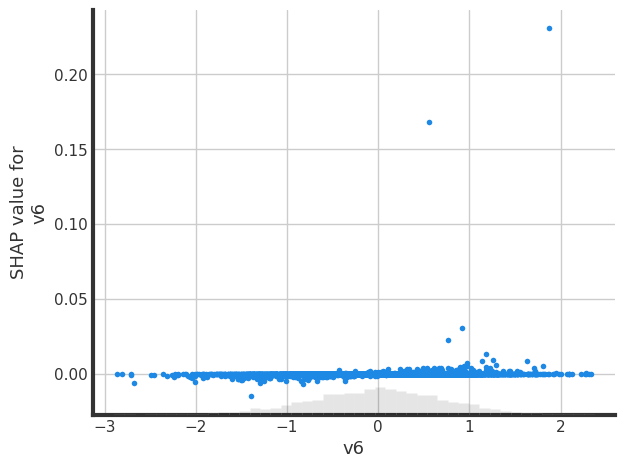

In [50]:
shap.plots.scatter(shap_values[:,"v6"])